# Test_ImageDataGenerator

## 1. Preprocess

### Import pkgs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.metrics import log_loss, accuracy_score
from IPython.display import display
import skimage
%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2
import cv2

### Run name

In [3]:
project_name = 'SC_Iceberg_Classifier'
step_name = 'Test_ImageDataGenerator'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: SC_Iceberg_Classifier_Test_ImageDataGenerator_20180107_074121


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/input
log_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/log
model_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/model
output_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/output


### Basic functions

In [5]:
import sys
def describe(arr):
    print(arr.shape, arr.min(), arr.max(), sys.getsizeof(arr))

In [6]:
def show_data_images(rows, fig_column, id_data, y_data, *args):
    columns = len(args)
    figs, axes = plt.subplots(rows, columns, figsize=(rows, fig_column*columns))
    print(axes.shape)  
    for i, ax in enumerate(axes):
        y_data_str = ''
        if type(y_data) != type(None):
            y_data_str =  '_' + str(y_data[i])
        ax[0].set_title(id_data[i] + y_data_str)
        for j, arg in enumerate(args):
            ax[j].imshow(arg[i])

### Load data

In [7]:
%%time
id_data_path = os.path.join(input_path, 'id_data.p')
id_test_path = os.path.join(input_path, 'id_test.p')
id_data = pickle.load(open(id_data_path, mode='rb'))
id_test = pickle.load(open(id_test_path, mode='rb'))

is_iceberg_path = os.path.join(input_path, 'is_iceberg.p')
y_data = pickle.load(open(is_iceberg_path, mode='rb'))

band1_data_path = os.path.join(input_path, 'band1_data.p')
band2_data_path = os.path.join(input_path, 'band2_data.p')
band1_test_path = os.path.join(input_path, 'band1_test.p')
band2_test_path = os.path.join(input_path, 'band2_test.p')

band1_data = pickle.load(open(band1_data_path, mode='rb'))
band2_data = pickle.load(open(band2_data_path, mode='rb'))
band1_test = pickle.load(open(band1_test_path, mode='rb'))
band2_test = pickle.load(open(band2_test_path, mode='rb'))

describe(band1_data)
describe(band2_data)
describe(band1_test)
describe(band2_test)

(1604, 75, 75) -45.594448 34.574917 128
(1604, 75, 75) -45.655499 20.154249 128
(8424, 75, 75) -45.6805458069 37.090523 128
(8424, 75, 75) -49.0835 37.0905227661 128
CPU times: user 380 ms, sys: 1.04 s, total: 1.42 s
Wall time: 1.42 s


In [8]:
%%time
band1_data_gray_path = os.path.join(input_path, 'band1_data_gray.p')
band2_data_gray_path = os.path.join(input_path, 'band2_data_gray.p')
band1_test_gray_path = os.path.join(input_path, 'band1_test_gray.p')
band2_test_gray_path = os.path.join(input_path, 'band2_test_gray.p')

band1_data_gray = pickle.load(open(band1_data_gray_path, mode='rb'))
band2_data_gray = pickle.load(open(band2_data_gray_path, mode='rb'))
band1_test_gray = pickle.load(open(band1_test_gray_path, mode='rb'))
band2_test_gray = pickle.load(open(band2_test_gray_path, mode='rb'))

describe(band1_data_gray)
describe(band2_data_gray)
describe(band1_test_gray)
describe(band2_test_gray)

(1604, 75, 75) 0.0 1.0 128
(1604, 75, 75) 0.0 1.0 128
(8424, 75, 75) 0.0 1.0 128
(8424, 75, 75) 0.0 1.0 128
CPU times: user 420 ms, sys: 996 ms, total: 1.42 s
Wall time: 1.41 s


(6, 4)


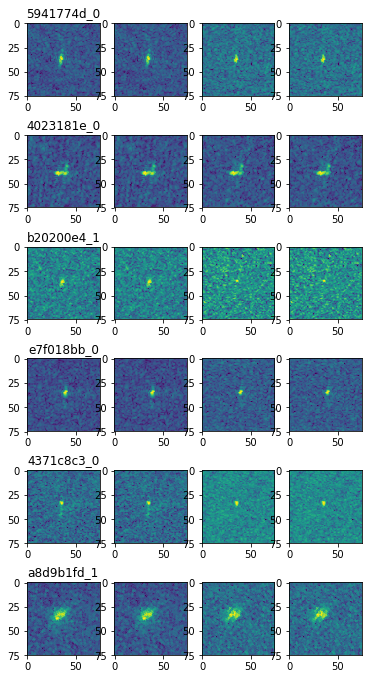

In [9]:
show_data_images(6, 3, id_test, y_data, band1_data, band1_data_gray, band2_data, band2_data_gray)

(6, 4)


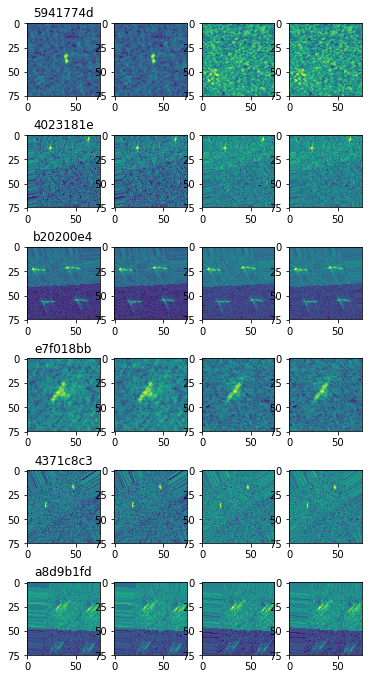

In [10]:
show_data_images(6, 3, id_test, None, band1_test, band1_test_gray, band2_test, band2_test_gray)

### Test ImageDataGenerator

In [11]:
band_data_gray_avg = (band1_data_gray + band2_data_gray)/2

In [12]:
x_data1 = np.concatenate([band1_data_gray[:, :, :, np.newaxis],
                         band2_data_gray[:, :, :, np.newaxis],
                         band_data_gray_avg[:, :, :, np.newaxis]], axis=-1)
describe(x_data1)

(1604, 75, 75, 3) 0.0 1.0 216540144


In [13]:
from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True)
datagen = ImageDataGenerator()

Using TensorFlow backend.


In [14]:
n = 6
batch_size = 6
x1 = []
y1 = []
for x_batch, y_batch in datagen.flow(x_data1[:n], y_data[:n], batch_size=batch_size, shuffle=False):
    x1.append(x_batch)
    y1.append(y_batch)
    break
x1 = np.concatenate(x1)
y1 = np.concatenate(y1)

(6, 2)


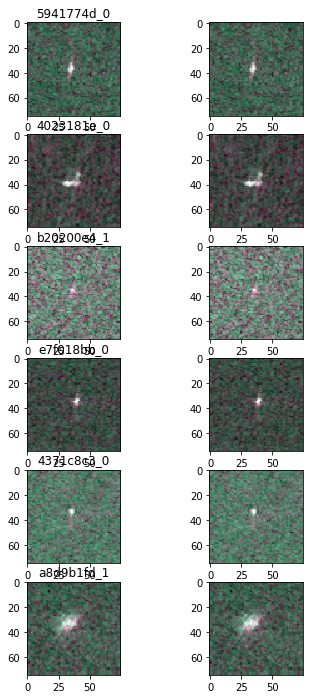

In [15]:
show_data_images(6, 6, id_test[:batch_size], y1, x_data1[:batch_size], x1)

In [16]:
datagen = ImageDataGenerator(
#     zoom_range=0.1,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True)

In [17]:
n = 6
batch_size = 6
x1 = []
y1 = []
for x_batch, y_batch in datagen.flow(x_data1[:n], y_data[:n], batch_size=batch_size, shuffle=False):
    x1.append(x_batch)
    y1.append(y_batch)
    break
x1 = np.concatenate(x1)
y1 = np.concatenate(y1)

(6, 2)


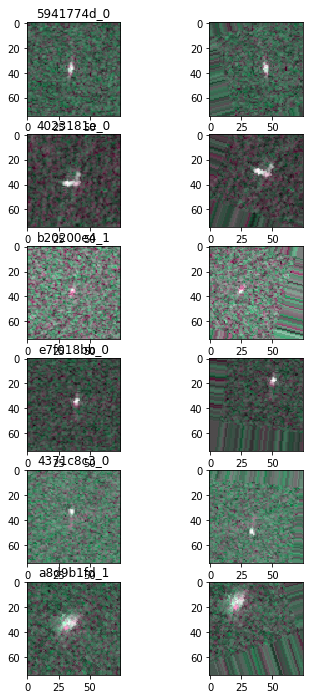

In [18]:
show_data_images(6, 6, id_test[:batch_size], y1, x_data1[:batch_size], x1)

In [19]:
t1 = time.time()
print('time cost: %.2f s' % (t1-t0))
print('Done!')

time cost: 9.97 s
Done!


In [20]:
print(run_name)

SC_Iceberg_Classifier_Test_ImageDataGenerator_20180107_074121
